# Clustering Jerárquico en el Dataset Zoo
Este notebook es una base para la tarea de clustering jerárquico usando el dataset Zoo.

In [3]:
# Paso 1: Cargar el dataset
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data"
columns = [
    "animal_name","hair","feathers","eggs","milk","airborne","aquatic",
    "predator","toothed","backbone","breathes","venomous","fins","legs",
    "tail","domestic","catsize","class_type"
]

df = pd.read_csv(url, header=None, names=columns)
print("First 5 records:\n", df.head())

First 5 records:
   animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0    aardvark     1         0     0     1         0        0         1   
1    antelope     1         0     0     1         0        0         0   
2        bass     0         0     1     0         0        1         1   
3        bear     1         0     0     1         0        0         1   
4        boar     1         0     0     1         0        0         1   

   toothed  backbone  breathes  venomous  fins  legs  tail  domestic  catsize  \
0        1         1         1         0     0     4     0         0        1   
1        1         1         1         0     0     4     1         0        1   
2        1         1         0         0     1     0     1         0        0   
3        1         1         1         0     0     4     0         0        1   
4        1         1         1         0     0     4     1         0        1   

   class_type  
0           1  
1           1  
2 

In [4]:
# Paso 2: Preprocesamiento (One Hot Encoding y Escalamiento)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Verificar que df existe
print("Shape del dataset:", df.shape)

# Definir características categóricas y numéricas
categorical_features = ["class_type"]
numerical_features = [
    "hair", "feathers", "eggs", "milk", "airborne", "aquatic",
    "predator", "toothed", "backbone", "breathes", "venomous",
    "fins", "legs", "tail", "domestic", "catsize"
]

# Crear pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop='first'), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Ajustar y transformar los datos
pipeline.fit(df)
X_transformed = pipeline.transform(df)

print("Datos transformados shape:", X_transformed.shape)

Shape del dataset: (101, 18)
Datos transformados shape: (101, 22)


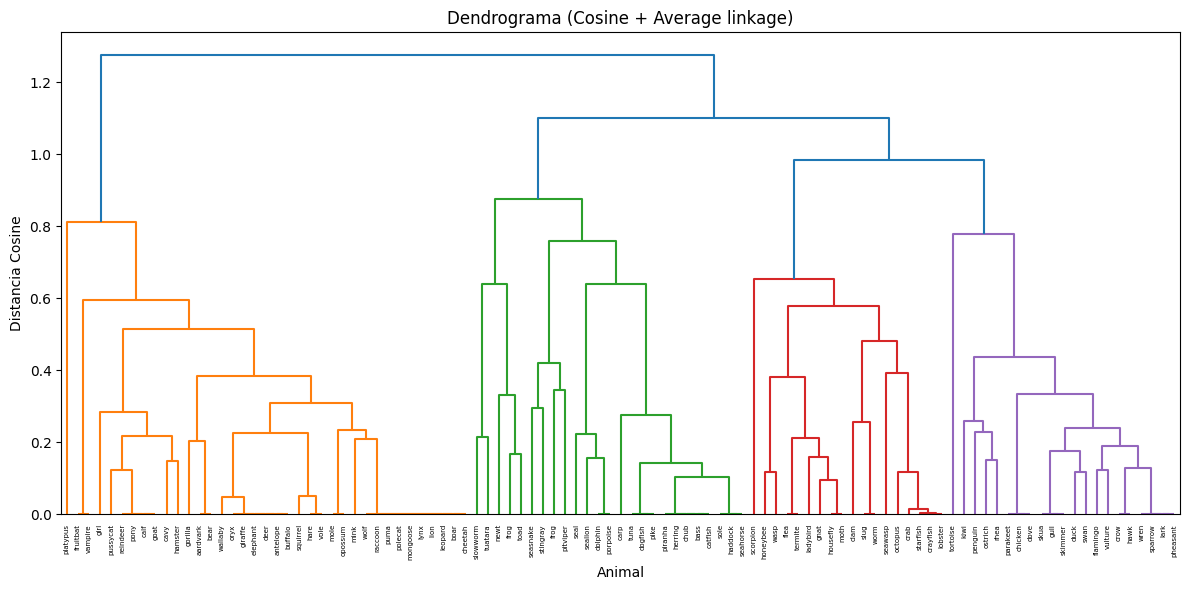

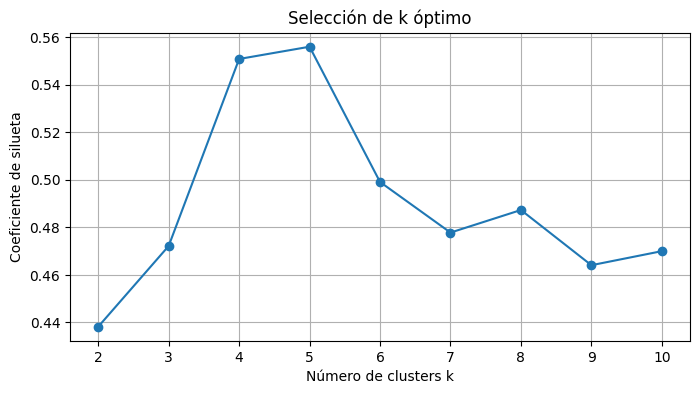

Número óptimo de clusters: 5
cluster
0    37
1    20
2    21
3    18
4     5
Name: count, dtype: int64


In [5]:
# Paso 3: Clustering Jerárquico 
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 1) Dendrograma con cosine similarity
linkage_matrix = linkage(X_transformed, method='average', metric='cosine')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df['animal_name'].values.tolist(), leaf_rotation=90)
plt.title('Dendrograma (Cosine + Average linkage)')
plt.xlabel('Animal')
plt.ylabel('Distancia Cosine')
plt.tight_layout()
plt.show()

# 2) Selección de k mediante coeficiente de silueta
sil_scores = []
ks = range(2, 11)
for k in ks:
    labels = AgglomerativeClustering(
        n_clusters=k, linkage='average', metric='cosine'
    ).fit_predict(X_transformed)
    sil_scores.append(silhouette_score(X_transformed, labels, metric='cosine'))

plt.figure(figsize=(8, 4))
plt.plot(ks, sil_scores, 'o-')
plt.xlabel('Número de clusters k')
plt.ylabel('Coeficiente de silueta')
plt.title('Selección de k óptimo')
plt.grid(True)
plt.show()

# 3) Clustering final con k óptimo
k_opt = ks[int(np.argmax(sil_scores))]
df['cluster'] = AgglomerativeClustering(
    n_clusters=k_opt, linkage='average', metric='cosine'
).fit_predict(X_transformed)

print(f'Número óptimo de clusters: {k_opt}')
print(df['cluster'].value_counts().sort_index())

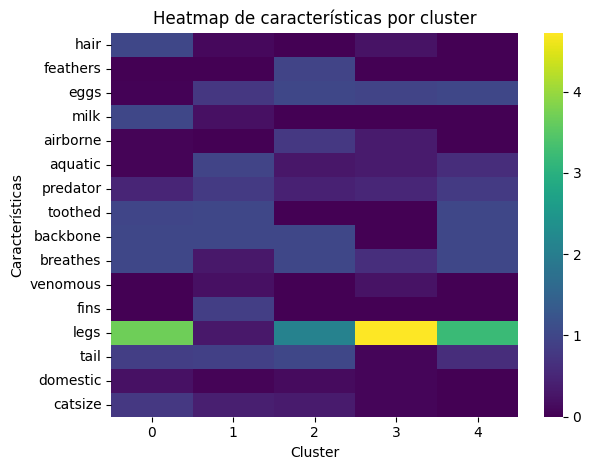

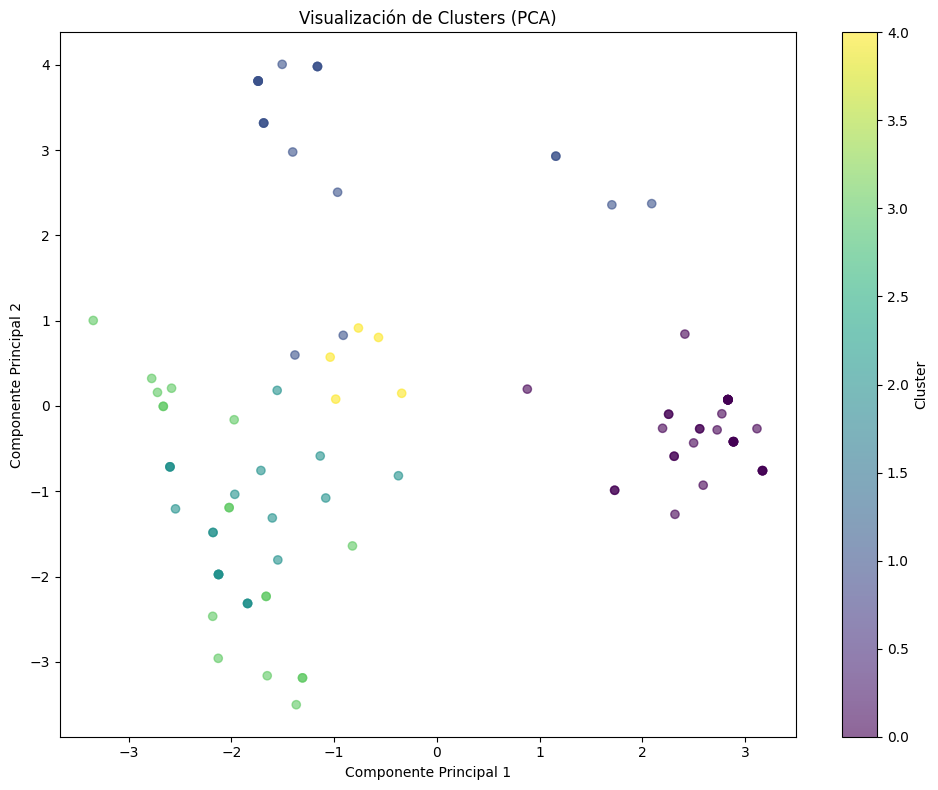

In [11]:
# Paso 4: Heatmap
import seaborn as sns
# Crear un DataFrame para el heatmap
numeric_features = [
    "hair", "feathers", "eggs", "milk", "airborne", "aquatic",
    "predator", "toothed", "backbone", "breathes", "venomous",
    "fins", "legs", "tail", "domestic", "catsize"
]
heatmap_data = df.groupby('cluster')[numeric_features].mean().T
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Heatmap de características por cluster')
plt.xlabel('Cluster')
plt.ylabel('Características')
plt.tight_layout()
plt.show()
# Paso 5: Visualización de Clusters
from sklearn.decomposition import PCA
# Reducir la dimensionalidad para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.title('Visualización de Clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()




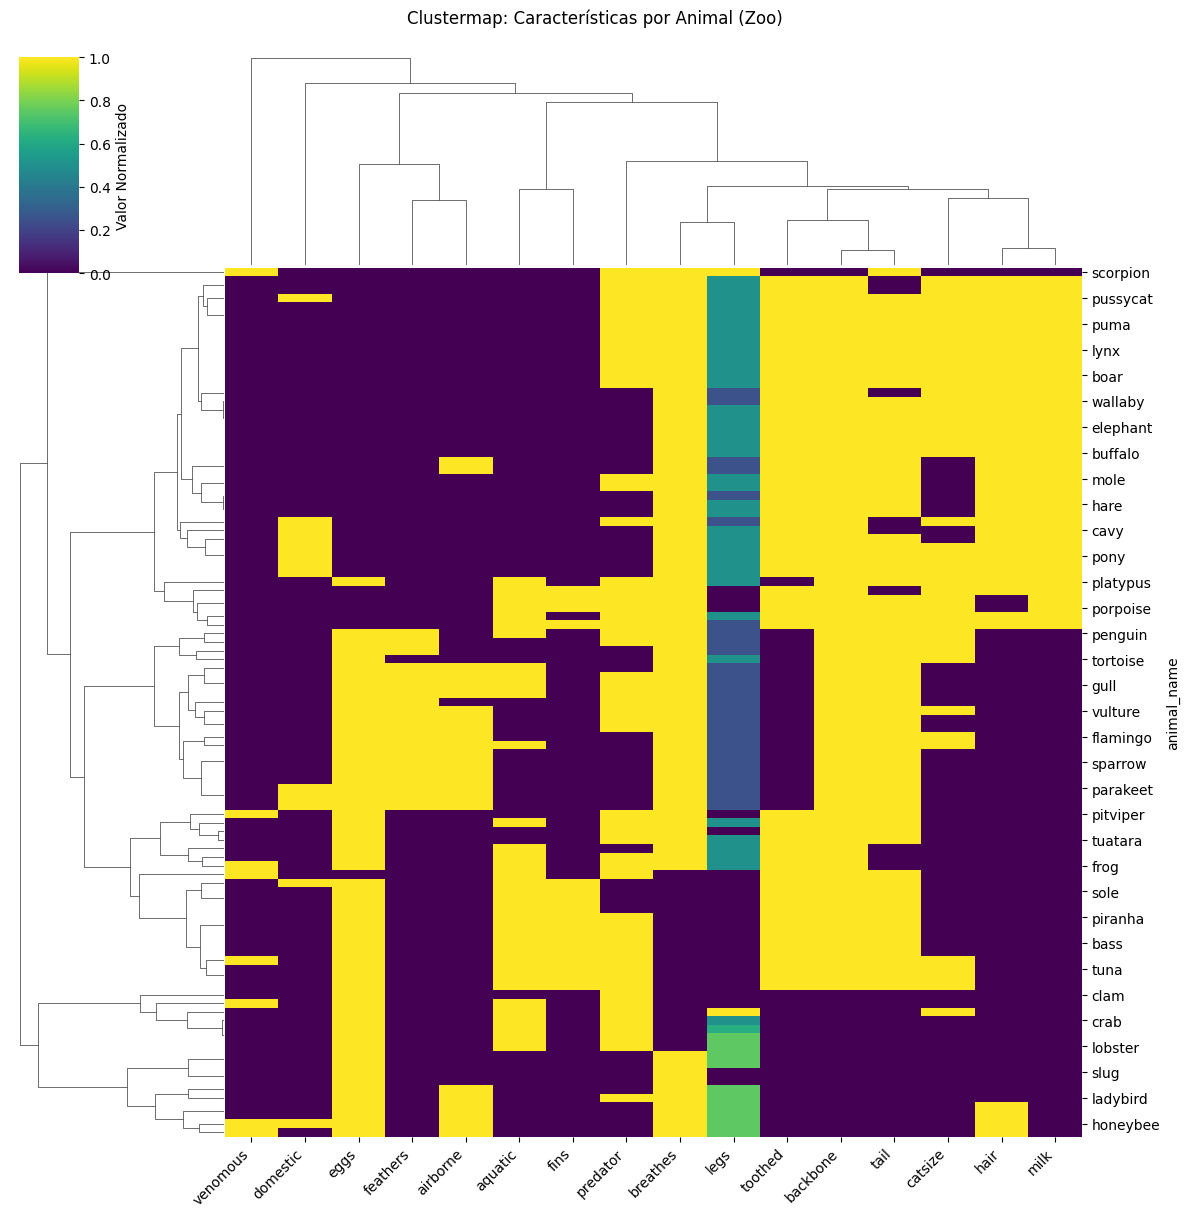

In [ ]:
# Paso 4: Clustermap al estilo del otro notebook

import seaborn as sns

# preparar datos: índice=animal_name, columnas=numéricas
numeric_features = [
    "hair","feathers","eggs","milk","airborne","aquatic",
    "predator","toothed","backbone","breathes","venomous",
    "fins","legs","tail","domestic","catsize"
]
data_for_clustermap = df.set_index('animal_name')[numeric_features]

# dibujar clustermap con dendrogramas en ambos ejes
cg = sns.clustermap(
    data_for_clustermap,
    method="average",        
    metric="cosine",         # distancia
    standard_scale=1,        # normalizar por columnas
    cmap="viridis",          # paleta
    figsize=(12, 12),
    robust=True,             # ignorar outliers extremos
    cbar_kws={'label': 'Valor Normalizado'}
)

# rotar y ajustar etiquetas 
cg.ax_heatmap.set_xticklabels(
    cg.ax_heatmap.get_xticklabels(), 
    rotation=45, 
    ha='right'
)
cg.ax_heatmap.set_yticklabels(
    cg.ax_heatmap.get_yticklabels(), 
    rotation=0
)

plt.suptitle('Clustermap: Características por Animal (Zoo)', y=1.02)
plt.show()

In [ ]:
# Renombrar las columnas para que pongan Cluster 0, Cluster 1, …
heatmap_data.columns = [f"Cluster {c}" for c in heatmap_data.columns]

# Dibujar el heatmap con valores anotados
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,      # muestra el número dentro de cada celda
    fmt=".2f",
    cbar_kws={'label':'Valor Normalizado'}
)
plt.xticks(rotation=45, ha='right')
plt.title('Heatmap de características por cluster')
plt.show()

# Conclusiones
Escribe aquí tus conclusiones sobre las agrupaciones obtenidas en el clustering jerárquico.

## Pregunta 1
1. ¿Cuántos clusters se pueden identificar claramente en el dendrograma?

se logran identificar al ojo 4 clusters en el dendograma del paso 3

## Pregunta 2
2. ¿Qué características parecen determinar la formación de los clusters?

- hair y milk: separan claramente a los mamíferos (peludos, que lactan).  
- feathers y eggs: agrupan a las aves y otros animales ovíparos.  
- aquatic y fins: identifican al cluster de especies acuáticas.  
- airborne: distingue a los voladores (aves y murciélagos).  
- legs (número de patas): discrimina entre bípodos, cuadrúpedos y especies con múltiples patas.
  
En conjunto, estos atributos binarios configuran perfiles de similitud muy marcados en el dendrograma. 


## Pregunta 3
3. ¿Los resultados del clustering tienen sentido biológico o zoológico?

Sí. Al analizar el heatmap de características por cluster vemos perfiles coherentes con grupos zoológicos conocidos:
- Cluster 1: alto en `hair` y `milk`, bajo en `eggs` corresponde a mamíferos vivíparos.  
- Cluster 4: alto en `aquatic` y `fins` corresponde a  especies acuáticas (peces, moluscos).  
- Cluster 2: intermedio en `feathers` y `eggs` corresponde a aves y otros ovíparos.  
- Cluster 3: muy alto en `legs` corresponde a artróp
odos/insectos.  
- Cluster 0: mezcla de valores intermedios, corresponde a reptiles y mamíferos pequeños terrestres.  

Estas divisiones coinciden con categorías biológicas (mamíferos, aves, peces, insectos, reptiles), por lo que el clustering refleja relaciones zoológicas reales.

## Pregunta 4
4. ¿Cómo afecta la normalización de los datos al clustering?


La normalización (escalar cada variable a media 0 y varianza 1) impide que atributos con rangos mayores (por ejemplo, número de patas) dominen la medida de distancia, equilibrando la influencia de variables binarias y continuas. Gracias a ello, el algoritmo agrupa según patrones reales de similitud y no por diferencias de escala entre características.


## Pregunta 5
5. ¿Qué método de linkage utilizaste y por qué?

Utilicé el método Average Linkage porque calcula la distancia promedio entre todos los puntos de dos clusters, produciendo agrupaciones más balanceadas y robustas ante outliers que single o complete linkage. Es especialmente apropiado para la distancia coseno y datos binarios como los del dataset Zoo, ya que considera todas las similitudes entre elementos de diferentes clusters, permitiendo formar grupos biológicamente coherentes donde los animales comparten características similares en promedio.

## Pregunta 6
6. ¿Qué otras técnicas de clustering podrías aplicar a este dataset y por qué?

La eleccion dependeria del objetivo que se quiere lograr con el modelo, pero algunas opciones son:

- **Clustering Categorical (K-Modes)**: Diseñado específicamente para variables categóricas/binarias como las del Zoo, usando distancia de Hamming en lugar de euclidiana.

- **K-Means**: Eficiente para encontrar clusters esféricos, usando distancia euclidiana después de normalización. Requiere especificar k a priori pero es computacionalmente rápido.